In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '15'
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2024-05-10 12:12:42.281822: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 12:12:42.308822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 12:12:42.308849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 12:12:42.309520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 12:12:42.313923: I tensorflow/core/platform/cpu_feature_guar

In [2]:
base_dir = 'ratings.csv'

In [3]:
df = pd.read_csv(base_dir)

In [4]:
df[:5]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df.drop(columns=[df.columns[-1]], inplace=True)

In [6]:
df[:5]

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
train, validation = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
n_users = len(df.userId.unique())
n_movie = len(df.movieId.unique())

print(n_users)
print(n_movie)

610
9724


In [9]:
len(df)

100836

In [10]:
n_movie * n_users

5931640

In [11]:
def create_dataset(df):
    user_inputs = tf.data.Dataset.from_tensor_slices(df['userId'])
    movie_inputs = tf.data.Dataset.from_tensor_slices(df['movieId'])
    ratings = tf.data.Dataset.from_tensor_slices(df['rating'])
    dataset = tf.data.Dataset.zip(((user_inputs, movie_inputs), ratings))
    dataset = dataset.shuffle(len(df))
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [12]:
train_dataset = create_dataset(train)
validation_dataset = create_dataset(validation)

2024-05-10 12:12:51.600756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:12:51.618365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 12:12:51.618511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
movie_input = tf.keras.layers.Input(shape=[1], name="movie-Input")
movie_embedding = tf.keras.layers.Embedding(n_movie+1, 5, name="movie-Embedding")(movie_input)
movie_vec = tf.keras.layers.Flatten(name="Flatten-movie")(movie_embedding)
movie_drop = tf.keras.layers.Dropout(0.2)(movie_vec)
Dense_movie = tf.keras.layers.Dense(128, activation='relu')(movie_drop)

user_input = tf.keras.layers.Input(shape=[1], name="User-Input")
user_embedding = tf.keras.layers.Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = tf.keras.layers.Flatten(name="Flatten-Users")(user_embedding)
user_drop = tf.keras.layers.Dropout(0.2)(user_vec)
Dense_user = tf.keras.layers.Dense(128, activation='relu')(user_drop)

concat = tf.keras.layers.Concatenate(name="deep_Concatenate")([Dense_movie, Dense_user])
drop1 = tf.keras.layers.Dropout(0.2)(concat)
Dense = tf.keras.layers.Dense(64, activation='relu')(drop1)
drop = tf.keras.layers.Dropout(0.2)(Dense)
out = tf.keras.layers.Dense(1)(drop)

model_ = tf.keras.models.Model([user_input, movie_input], out)
model_.compile('adam', 'mean_squared_error')

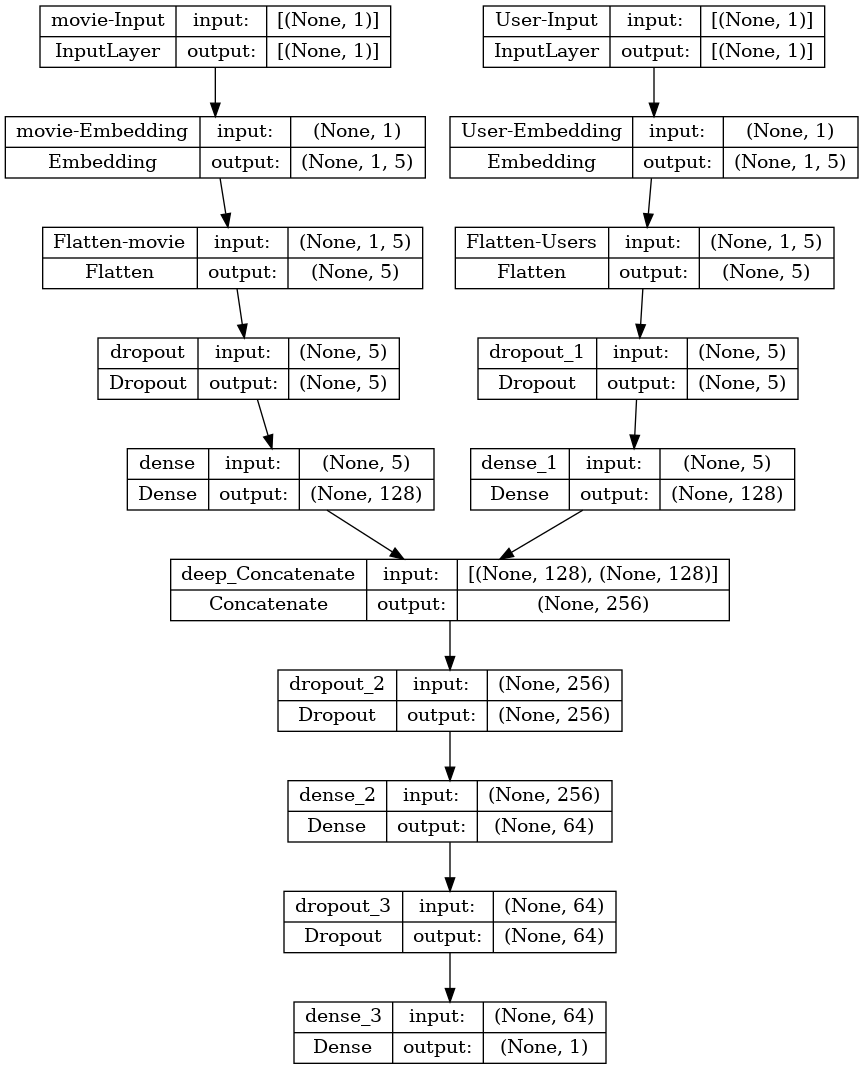

In [14]:
keras.utils.plot_model(model_, show_shapes=True)

In [15]:
from keras.callbacks import ReduceLROnPlateau

history = model_.fit(train_dataset, epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20


2024-05-10 12:13:20.005262: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-10 12:13:20.719092: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fda9c9e1ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-10 12:13:20.719115: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX330, Compute Capability 6.1
2024-05-10 12:13:20.723149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-10 12:13:20.733852: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1715357600.792672   10502 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2521/2521 [==============================] - 8s 2ms/step - loss: 1.1287 - val_loss: 0.8126
Epoch 2/20
2521/2521 [==============================] - 5s 2ms/step - loss: 0.8837 - val_loss: 0.7950
Epoch 3/20
2521/2521 [==============================] - 5s 2ms/step - loss: 0.8365 - val_loss: 0.7923
Epoch 4/20
2521/2521 [==============================] - 5s 2ms/step - loss: 0.8062 - val_loss: 0.7958
Epoch 5/20
2521/2521 [==============================] - 5s 2ms/step - loss: 0.7853 - val_loss: 0.7947
Epoch 6/20
2521/2521 [==============================] - 5s 2ms/step - loss: 0.7708 - val_loss: 0.8066
Epoch 7/20
2521/2521 [==============================] - 5s 2ms/step - loss: 0.7587 - val_loss: 0.7902
Epoch 8/20
2521/2521 [==============================] - 6s 2ms/step - loss: 0.7462 - val_loss: 0.7935
Epoch 9/20
2521/2521 [==============================] - 6s 2ms/step - loss: 0.7364 - val_loss: 0.7802
Epoch 10/20
2521/2521 [==============================] - 5s 2ms/step - loss: 0.7251 - val_los

In [16]:
if os.path.exists('t4_model.h5'):
    model = load_model('t4_model.h5')
else:                   
    model_4.save('t4_model.h5')

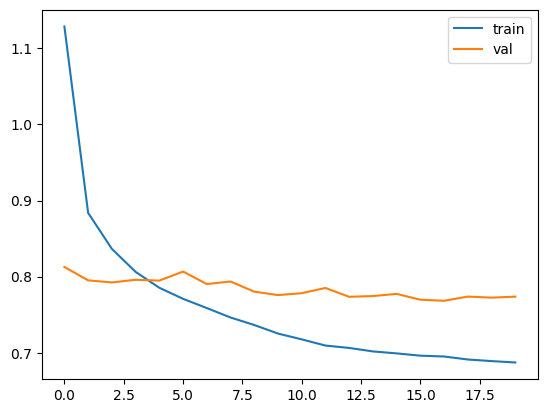

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["train", "val"])

In [19]:
predictions = model_.predict(validation_dataset)
predicted_rating = tf.math.argmax(predictions, axis=-1)

631/631 [==============================] - 0s 605us/step


In [24]:
user_249 = 249
user_249_inputs = np.array([user_249] * n_movie)  
movie_ids = np.array(range(1, n_movie + 1)) 

predicted_ratings = model_.predict([user_249_inputs, movie_ids])

top_10_indices = np.argsort(predicted_ratings.flatten())[::-1][:10]

print("Top 10 Recommendations for User 249:")
for i, idx in enumerate(top_10_indices, 1):
    movie_id = idx + 1 
    print(f"{i}. Movie ID: {movie_id}, Predicted Rating: {predicted_ratings[idx][0]}")


304/304 [==============================] - 0s 602us/step
Top 10 Recommendations for User 249:
1. Movie ID: 4789, Predicted Rating: 4.763479232788086
2. Movie ID: 6460, Predicted Rating: 4.693575859069824
3. Movie ID: 53, Predicted Rating: 4.675882339477539
4. Movie ID: 7767, Predicted Rating: 4.608813762664795
5. Movie ID: 905, Predicted Rating: 4.600699424743652
6. Movie ID: 6235, Predicted Rating: 4.590969085693359
7. Movie ID: 2360, Predicted Rating: 4.586467742919922
8. Movie ID: 3451, Predicted Rating: 4.584613800048828
9. Movie ID: 8405, Predicted Rating: 4.565370082855225
10. Movie ID: 670, Predicted Rating: 4.561892032623291
